# Linear Regression: Car Insurance Claim Prediction
### Setting up the model using numerical features alone



In [1]:
import numba.core.bytecode
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.display.max_rows = 100
import warnings

import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
def Remove_Outlier_Indices(df):
    """ returns a df of boolean values to used to index a trimmed table in the 1.5*IQR range"""
    if isinstance(df,pd.core.frame.DataFrame):
        Q1 = df.quantile(0.25)
        Q3 = df.quantile(0.75)
        IQR = Q3 - Q1
        trueList = ~((df < (Q1 - 1.5*IQR)) |(df > (Q3 + 1.5*IQR)))
    else:
        raise TypeError
    return trueList

In [3]:
c_df = pd.read_csv('Data_Marketing_Customer_Analysis_Round3.csv')

In [4]:
c_df.columns

Index(['Unnamed: 0', 'region', 'customer_lifetime_value', 'response',
       'coverage', 'education', 'effective_to_date', 'month',
       'employment_status', 'gender', 'income', 'location_code',
       'marital_status', 'monthly_premium_auto', 'months_since_last_claim',
       'months_since_policy_inception', 'number_of_open_complaints',
       'number_of_policies', 'policy_type', 'policy', 'renew_offer_type',
       'sales_channel', 'total_claim_amount', 'vehicle_class', 'vehicle_size'],
      dtype='object')

In [5]:
c_df.drop(['Unnamed: 0','effective_to_date'],axis=1,inplace=True)

In [6]:
nums  = c_df.select_dtypes(exclude=object)
cats  = c_df.select_dtypes(include=object)

X = nums.drop(['total_claim_amount'], axis=1) # trimmed target var
y = nums.total_claim_amount # trimmed independent var (vec)`

In [7]:
TEST_SIZE = .25
RANDOM_STATE = 123 # reproduce the same results. disables randomization

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE,random_state=RANDOM_STATE)

In [8]:
transformer = StandardScaler()
X_train = transformer.fit_transform(X_train)
#transformer.fit(X_train)
#X_train = transformer.transform(X_train)
X_test  = transformer.transform(X_test)

### Apply linear regression model

In [9]:
model = LinearRegression()   # model is y = SUM(slopes*Xs) + intercept
model.fit(X_train, y_train) # compute for me the coefficients (slopes and intercept)
y_pred       = model.predict(X_test)   # model prediction [test]
y_pred_train = model.predict(X_train)  # model prediction [train]

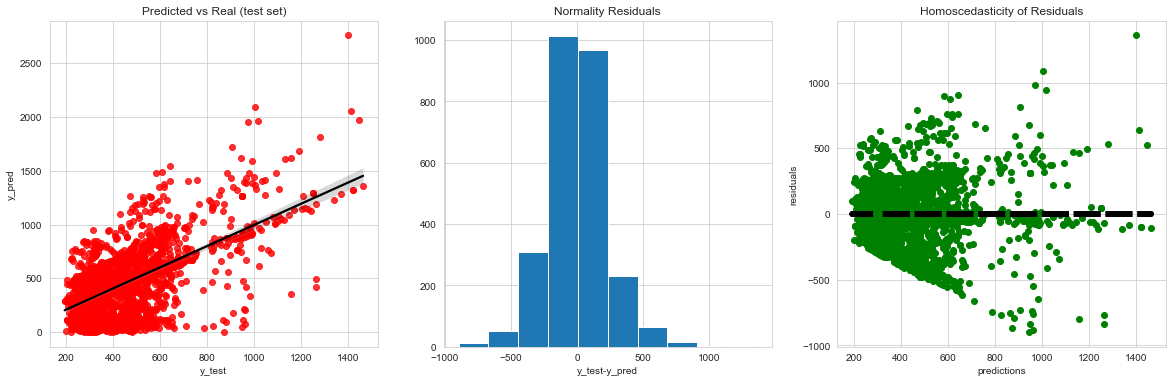

In [10]:
fig, ax = plt.subplots(1,3,figsize=(20,6))

# forms a line?
sns.regplot(x='y_pred',y='y_test', data=pd.DataFrame({"y_test": y_test, "y_pred": y_pred}) ,
            scatter_kws={"color": "red"}, line_kws={"color": "black"}, ax=ax[0])
#ax[0].plot(y_pred, y_test, 'o')
ax[0].set_xlabel("y_test")
ax[0].set_ylabel("y_pred")
ax[0].set_title("Predicted vs Real (test set)")

# normal distribution?
ax[1].hist(y_test - y_pred)
ax[1].set_xlabel("y_test-y_pred")
ax[1].set_title("Normality Residuals")

# constant?
ax[2].plot(y_pred,y_test - y_pred,"o",color='green')
ax[2].set_xlabel("predictions")
ax[2].set_ylabel("residuals")
ax[2].set_title("Homoscedasticity of Residuals")
ax[2].plot(y_pred,np.zeros(len(y_pred)),linestyle='dashed',linewidth=6,color='black')


In [11]:
R2=r2_score(y_test,y_pred)
Adj_R2= 1 - (1-R2)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
print("the performance scores are r2={:3f} and r2_adj={:3f}".format(R2,Adj_R2))

the performance scores are r2=0.405793 and r2_adj=0.404232


In [12]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [13]:
X_train_const = sm.add_constant(X_train) # adding a constant
X_test_const  = sm.add_constant(X_test) # adding a constant

model = sm.OLS(y_train, X_train_const).fit()

predictions_train = model.predict(X_train_const)
predictions_test  = model.predict(X_test_const)

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:     total_claim_amount   R-squared:                       0.411
Model:                            OLS   Adj. R-squared:                  0.410
Method:                 Least Squares   F-statistic:                     798.3
Date:                Thu, 02 Feb 2023   Prob (F-statistic):               0.00
Time:                        10:27:45   Log-Likelihood:                -54822.
No. Observations:                8016   AIC:                         1.097e+05
Df Residuals:                    8008   BIC:                         1.097e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        432.2534      2.524    171.232      0.0

In [14]:
from statsmodels.formula.api import ols

In [15]:
headers = list(nums.columns)[:-1]
headers

['customer_lifetime_value',
 'income',
 'monthly_premium_auto',
 'months_since_last_claim',
 'months_since_policy_inception',
 'number_of_open_complaints',
 'number_of_policies']

In [16]:
eqn = 'total_claim_amount~' + '+'.join(headers)
eqn

'total_claim_amount~customer_lifetime_value+income+monthly_premium_auto+months_since_last_claim+months_since_policy_inception+number_of_open_complaints+number_of_policies'

In [17]:
X_train_df = pd.DataFrame(X_train, columns=headers)
y_train_df = pd.DataFrame(y_train)
y_train_df.reset_index(drop=True, inplace=True)
y_train_df
data = pd.concat([X_train_df, y_train_df], axis=1)

In [18]:
#data = pd.concat([X_train_df, y_train_df], axis=1)

In [19]:
data

,customer_lifetime_value,income,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies,total_claim_amount
0,-0.063191,1.425385,0.055465,1.279287,-1.469007,-0.425641,2.104132,448
1,-0.488120,-1.591806,0.922819,1.080989,1.147004,-0.425641,-0.819405,600
2,-0.528721,0.276829,0.489142,-0.901987,0.931989,-0.425641,-0.819405,528
3,-0.063480,0.515879,-0.840801,0.783543,-1.038978,-0.425641,-0.401757,268
4,-0.557473,-1.614752,0.691525,-0.802838,-0.071412,-0.425641,-0.819405,561
...,...,...,...,...,...,...,...,...
8011,-0.713083,0.882417,-0.493860,1.874180,0.000259,-0.425641,-0.819405,53
8012,-0.341469,1.078824,-0.609507,-0.108797,-1.003142,1.777742,2.104132,345
8013,-0.807287,-1.159678,-0.898625,-1.001136,-1.397335,-0.425641,-0.819405,500
8014,2.250005,0.979498,-0.782978,0.981841,-1.612350,-0.425641,-0.401757,86


In [20]:
model = ols(formula=eqn,data=data).fit()

In [21]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     total_claim_amount   R-squared:                       0.411
Model:                            OLS   Adj. R-squared:                  0.410
Method:                 Least Squares   F-statistic:                     798.3
Date:                Thu, 02 Feb 2023   Prob (F-statistic):               0.00
Time:                        10:27:45   Log-Likelihood:                -54822.
No. Observations:                8016   AIC:                         1.097e+05
Df Residuals:                    8008   BIC:                         1.097e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                       432.2534      2.524    171.232      0.000     427.305     437.202
customer_lifetime_value          -5.8137      2.754     -2.111      0.035     -11.213      -0.414
income                          -32.7779      2.526    -12.975      0.000     -37.730     -27.826
monthly_premium_auto            187.8082      2.753     68.216      0.000     182.411     193.205
months_since_last_claim           1.6981      2.528      0.672      0.502      -3.257       6.654
months_since_policy_inception    -0.8840      2.528     -0.350      0.727      -5.840       4.072
number_of_open_complaints         1.9107      2.526      0.756      0.449      -3.041       6.862
number_of_policies               -1.8027      2.526     -0.714      0.476      -6.755       3.150
==============================================================================
Omnibus:                     1043.312   Durbin-Watson:                   2.028
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5473.100
Skew:                           0.517   Prob(JB):                         0.00
Kurtosis:                       6.914   Cond. No.                         1.53
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [22]:
sigparams = model.params[list(np.where(model.pvalues < 0.05)[0])].iloc[0:].index.tolist()
sigparams

['Intercept', 'customer_lifetime_value', 'income', 'monthly_premium_auto']

In [23]:
eqn = 'total_claim_amount~' + '+'.join(sigparams[1:])

In [24]:
X_train_df = X_train_df[sigparams[1:]]
data = pd.concat([X_train_df, y_train_df], axis=1)

In [25]:
model = ols(formula=eqn,data=data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     total_claim_amount   R-squared:                       0.411
Model:                            OLS   Adj. R-squared:                  0.411
Method:                 Least Squares   F-statistic:                     1863.
Date:                Thu, 02 Feb 2023   Prob (F-statistic):               0.00
Time:                        10:27:45   Log-Likelihood:                -54823.
No. Observations:                8016   AIC:                         1.097e+05
Df Residuals:                    8012   BIC:                         1.097e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 432.2534      2.524    171.257      0.000     427.306     437.201
customer_lifetime_value    -5.9353      2.751     -2.158      0.031     -11.328      -0.543
income                    -32.8200      2.524    -13.003      0.000     -37.768     -27.872
monthly_premium_auto      187.8867      2.751     68.300      0.000     182.494     193.279
==============================================================================
Omnibus:                     1044.685   Durbin-Watson:                   2.028
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5485.904
Skew:                           0.518   Prob(JB):                         0.00
Kurtosis:                       6.918   Cond. No.                         1.52
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""